<a href="https://colab.research.google.com/github/norhum/deep_learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader


In [26]:
# Define transformations for training and testing
transform = transforms.Compose([
    transforms.Resize(32),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained ImageNet normalization
])

# Load CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Load the pretrained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer to match the number of classes in CIFAR-10
num_classes = 10
print(model.fc.in_features)
model.fc = nn.Linear(model.fc.in_features, num_classes)


2048


In [28]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only for the final layer)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [29]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(sum(p.numel() for p in model.parameters()))
# Train for a few epochs
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


20490
23528522
Epoch 1/5, Loss: 1.7256, Test Accuracy: 48.56%
Epoch 2/5, Loss: 1.4761, Test Accuracy: 50.25%
Epoch 3/5, Loss: 1.4113, Test Accuracy: 52.26%
Epoch 4/5, Loss: 1.3724, Test Accuracy: 52.60%
Epoch 5/5, Loss: 1.3437, Test Accuracy: 52.97%


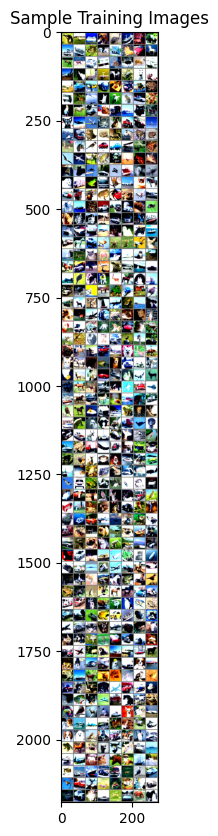

In [19]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import numpy as np

# Function to display a grid of images with their labels
def imshow(img, labels):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Sample Training Images")
    plt.show()

# Load a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid
imshow(torchvision.utils.make_grid(images), labels)
